# C3.ai COVID-19 Data Lake Quickstart in Python  

Version 5.0 (August 11, 2020).

This Jupyter notebook shows some examples of how to access and use each of the [C3.ai COVID-19 Data Lake](https://c3.ai/covid/) APIs. These examples show only a small piece of what you can do with the C3.ai COVID-19 Data Lake, but will get you started with performing your own exploration. See the [API documentation](https://c3.ai/covid-19-api-documentation/) for more details.

Please contribute your questions, answers and insights on [Stack Overflow](https://www.stackoverflow.com). Tag `c3ai-datalake` so that others can view and help build on your contributions. For support, please send email to: [covid@c3.ai](mailto:covid@c3.ai).

## Table of Contents
- [Helper methods for accessing the API](#helpers)
- [Access OutbreakLocation data](#outbreaklocation)
    - [Case counts](#outbreaklocation/casecounts)
    - [Demographics](#outbreaklocation/demographics)
    - [Mobility](#outbreaklocation/mobility)
    - [Projections](#outbreaklocation/projections)
    - [Economic indicators](#outbreaklocation/economics)
- [Access LocationExposure data](#locationexposure)
- [Access LineListRecord data](#linelistrecord)
- [Join BiologicalAsset and Sequence data](#biologicalasset)
- [Access BiblioEntry data](#biblioentry)
- [Join TherapeuticAsset and ExternalLink data](#therapeuticasset)
- [Join Diagnosis and DiagnosisDetail data](#diagnosis)
- [Access VaccineCoverage data](#vaccinecoverage)
- [Access Policy data](#policy)
- [Access LaborDetail data](#labor)
- [Access Survey data](#survey)

Import the [requests](https://requests.readthedocs.io/en/master/), [pandas>=1.0.0](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/3.2.1/index.html), and [scipy](https://www.scipy.org/) libraries before using this notebook.

In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
import numpy as np

Ensure that you have a recent version of pandas (>= 1.0.0).

In [2]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


pandas version 1.0.5


<a id="helpers"></a>
## Helper methods for accessing the API

The helper methods in `c3aidatalake.py` convert a JSON response from the C3.ai APIs to a Pandas DataFrame. You may wish to view the code in `c3aidatalake.py` before using the quickstart examples.

In [3]:
import c3aidatalake

<a id="outbreaklocation"></a>
## Access OutbreakLocation data

`OutbreakLocation` stores location data such as countries, provinces, cities, where COVID-19 outbeaks are recorded. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/OutbreakLocation) for more details and for a list of available locations.

In [4]:
# Fetch facts about Germany
locations = c3aidatalake.fetch(
    "outbreaklocation",
    {
        "spec" : {
            "filter" : "id == 'Germany'"
        }
    }
)

locations

,latestTotalPopulation,populationOfAllChildren,id,name,typeIdent,hospitalPrediction.timestamp,location.value.id,location.timestamp
0,71541906.0,71541906.0,Germany,Germany,EP_LOC,2021-02-20T08:01:12Z,Germany,2021-02-21T06:00:13Z


<a id="outbreaklocation/casecounts"></a>
### Case counts

A variety of sources provide counts of cases, deaths, recoveries, and other statistics for counties, provinces, and countries worldwide.

In [ ]:
# Total number of confirmed cases, deaths, and recoveries in Santa Clara, California
today = pd.Timestamp.now().strftime("%Y-%m-%d")

casecounts = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : ["SantaClara_California_UnitedStates"],
            "expressions" : ["JHU_ConfirmedCases", "JHU_ConfirmedDeaths", "JHU_ConfirmedRecoveries"],
            "start" : "2020-01-01",
            "end" : today,
            "interval" : "DAY",
        }
    }
)

casecounts

Plot these counts.

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(
    casecounts["dates"],
    casecounts["SantaClara_California_UnitedStates.JHU_ConfirmedCases.data"],
    label = "JHU_ConfirmedCases"
)
plt.plot(
    casecounts["dates"],
    casecounts["SantaClara_California_UnitedStates.JHU_ConfirmedDeaths.data"],
    label = "JHU_ConfirmedDeaths"
)
plt.plot(
    casecounts["dates"],
    casecounts["SantaClara_California_UnitedStates.JHU_ConfirmedRecoveries.data"],
    label = "JHU_ConfirmedCases"
)
plt.legend()
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Count")
plt.show()

Export case counts as a .csv file.

In [ ]:
# Uncomment the line below to export the DataFrame as a .csv file
# casecounts.to_csv("casecounts.csv")

<a id="outbreaklocation/demographics"></a>
### Demographics

Demographic and economic data from the US Census Bureau and The World Bank allow demographic comparisons across locations. 

In [ ]:
population = c3aidatalake.fetch(
    "populationdata",
    {
        "spec" : {
            "filter" : "!contains(parent, '_') && (populationAge == '>=65' || populationAge == 'Total') && gender == 'Male/Female' && year == '2018' && estimate == 'False' && percent == 'False'"
        }
    },
    get_all = True
)

population

In [ ]:
population_age_distribution = population.loc[
    :, 
    ["populationAge", "parent.id", "value"]
].pivot(index = "parent.id", columns = "populationAge")['value']
population_age_distribution["proportion_over_65"] = population_age_distribution[">=65"] / population_age_distribution["Total"]

population_age_distribution

Access global death counts.

In [ ]:
global_deaths = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : list(population_age_distribution.index),
            "expressions" : ["JHU_ConfirmedDeaths"],
            "start" : "2020-05-01",
            "end" : "2020-05-01",
            "interval" : "DAY",
        }
    },
    get_all = True
)

global_deaths

In [ ]:
global_deaths_by_country = global_deaths.filter(regex=("\.data")).melt()
global_deaths_by_country["country"] = global_deaths_by_country["variable"].str.replace("\..*", "")

global_comparison = global_deaths_by_country.set_index("country").join(population_age_distribution)
global_comparison["deaths_per_million"] = 1e6 * global_comparison["value"] / global_comparison["Total"] 
global_comparison

Plot the results.

In [ ]:
plt.figure(figsize = (8, 6))
plt.scatter(
    global_comparison["proportion_over_65"],
    global_comparison["deaths_per_million"]
)
plt.xlabel("Proportion of population over 65")
plt.ylabel("Confirmed COVID-19 deaths\nper million people")
plt.show()

<a id="outbreaklocation/mobility"></a>
### Mobility

Mobility data from Apple and Google provide a view of the impact of COVID-19 and social distancing on mobility trends.

In [11]:
mobility_trends = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : ["Illinois_UnitedStates"],
            "expressions" : [
                "Apple_WalkingMobility", 
                "Apple_DrivingMobility",
                "Google_ParksMobility",
                "Google_ResidentialMobility"
              ],
            "start" : "2020-01-22",
            "end" : "2020-11-01",
            "interval" : "DAY",
        }
    },
    get_all = True
)

mobility_trends

,dates,Illinois_UnitedStates.Apple_WalkingMobility.data,Illinois_UnitedStates.Apple_WalkingMobility.missing,Illinois_UnitedStates.Apple_DrivingMobility.data,Illinois_UnitedStates.Apple_DrivingMobility.missing,Illinois_UnitedStates.Google_ResidentialMobility.data,Illinois_UnitedStates.Google_ResidentialMobility.missing,Illinois_UnitedStates.Google_ParksMobility.data,Illinois_UnitedStates.Google_ParksMobility.missing
0,2020-01-22,103.72,0,100.94,0,0,100,0,100
0,2020-01-23,100.77,0,103.07,0,0,100,0,100
0,2020-01-24,132.23,0,121.44,0,0,100,0,100
0,2020-01-25,146.47,0,119.73,0,0,100,0,100
0,2020-01-26,92.85,0,86.67,0,0,100,0,100
...,...,...,...,...,...,...,...,...,...
0,2020-10-27,101.99,0,110.28,0,112,0,89,0
0,2020-10-28,111.02,0,113.82,0,111,0,109,0
0,2020-10-29,114.43,0,118.84,0,111,0,92,0
0,2020-10-30,147.48,0,143.65,0,110,0,113,0


Plot these mobility trends.

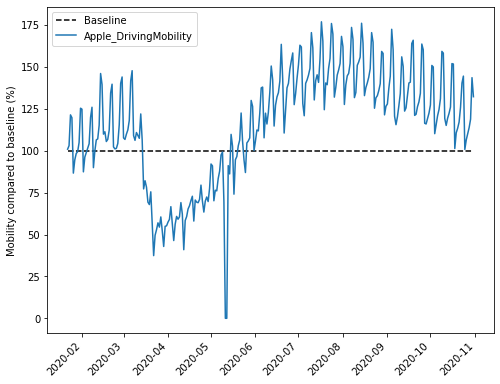

In [18]:
plt.figure(figsize = (8, 6))
plt.plot(
    mobility_trends["dates"],
    [100 for d in mobility_trends["dates"]],
    label = "Baseline",
    linestyle = "dashed",
    color = "black"
)
# plt.plot(
#     mobility_trends["dates"],
#     mobility_trends["Illinois_UnitedStates.Apple_WalkingMobility.data"],
#     label = "Apple_WalkingMobility"
# )
plt.plot(
    mobility_trends["dates"],
    mobility_trends["Illinois_UnitedStates.Apple_DrivingMobility.data"],
    label = "Apple_DrivingMobility"
)
# plt.plot(
#     mobility_trends["dates"],
#     mobility_trends["Illinois_UnitedStates.Google_ParksMobility.data"],
#     label = "Google_ParksMobility"
# )
# plt.plot(
#     mobility_trends["dates"],
#     mobility_trends["Illinois_UnitedStates.Google_ResidentialMobility.data"],
#     label = "Google_ResidentialMobility"
# )
plt.legend()
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Mobility compared to baseline (%)")
plt.savefig('/Users/zhangyuqi/Documents/NCSA/Exposure_Risk_Analysis_in Rural_Illinois/Plots/daily_mobility_trends.png', dpi = 200)



<a id="outbreaklocation/projections"></a>
### Projections

Use the `GetProjectionHistory` API to retrieve versioned time series projections for specific metrics made at specific points in time.

In [ ]:
# Retrieve projections made between April 13 and May 1 of mean total cumulative deaths in Spain from April 13 to May 13
projections = c3aidatalake.getprojectionhistory(
    {
        "outbreakLocation": "Spain", 
        "metric": "UniversityOfWashington_TotdeaMean_Hist",
        "metricStart": "2020-04-13", 
        "metricEnd": "2020-05-13",
        "observationPeriodStart": "2020-04-13",
        "observationPeriodEnd": "2020-05-01"
    }
)

projections

In [ ]:
# Retrieve actual total cumulative deaths in Spain from April 1 to May 13
deaths = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : ["Spain"],
            "expressions" : ["JHU_ConfirmedDeaths"],
            "start" : "2020-04-01",
            "end" : "2020-05-13",
            "interval" : "DAY",
        }
    }
)

deaths

Plot the results.

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(
    deaths["dates"],
    deaths["Spain.JHU_ConfirmedDeaths.data"],
    label = "JHU_ConfirmedDeaths",
    color = "black"
)
for col in projections.columns:
    if 'data' in col:
        expr = projections[col.replace("data", "expr")].iloc[0]
        projection_date = pd.to_datetime(expr.split(" ")[-1])
        plt.plot(
            projections.loc[projections["dates"] >= projection_date, "dates"],
            projections.loc[projections["dates"] >= projection_date, col],
            label = expr
        )

plt.legend()
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Count")
plt.title("Cumulative death count projections versus actual count")
plt.show()

<a id="outbreaklocation/economics"></a>
### Economic indicators

GDP and employment statistics by business sector from the US Bureau of Economic Analysis enable comparisons of the drivers of local economies. 

In [ ]:
# Real GDP for AccommodationAndFoodServices and FinanceAndInsurance in Alameda County, California

realgdp = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec": {
              "ids": ["Alameda_California_UnitedStates"], 
              "expressions": [
                "BEA_RealGDP_AccommodationAndFoodServices_2012Dollars",
                "BEA_RealGDP_FinanceAndInsurance_2012Dollars"

              ], 
              "start": "2000-01-01", 
              "end": "2020-01-01", 
              "interval":"YEAR"
        }
    }
)

realgdp

High frequency spending and earnings data from Opportunity Insights allow tracking of near real-time economic trends.

In [ ]:
# Access consumer spending in healthcare and low income earnings in the healthcare and social assistance sector in California
opportunityinsights = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec": {
            "ids": ["California_UnitedStates"], 
            "expressions": [
                "OIET_Affinity_SpendHcs",
                "OIET_LowIncEmpAllBusinesses_Emp62"
            ], 
            "start": "2020-01-01", 
            "end": "2020-06-01", 
            "interval":"DAY"
        }
    }
)
    
opportunityinsights

Plot the results.

In [ ]:
plt.figure(figsize = (8, 6))

plt.plot(
    opportunityinsights.dates,
    opportunityinsights['California_UnitedStates.OIET_Affinity_SpendHcs.data'] * 100,
    label = 'Consumer spending in healthcare'
)

plt.plot(
    opportunityinsights.dates,
    opportunityinsights['California_UnitedStates.OIET_LowIncEmpAllBusinesses_Emp62.data'] * 100,
    label = 'Low income earnings in\nhealthcare & social assistance '
)

plt.legend()
plt.title("California low-income earnings and consumer spending in healthcare")
plt.xlabel("Date")
plt.xticks(rotation = 45, ha = "right")
plt.ylabel("Change relative to January 4-31 (%)")

plt.show()

<a id="locationexposure"></a>
## Access Location Exposure data

`LocationExposure` stores information based on the movement of people's mobile devices across locations over time. It stores the following:  
* Location exposure index (LEX) for a pair of locations (`locationTarget`, `locationVisited`): the fraction of mobile devices that pinged in `locationTarget` on a date that also pinged in `locationVisited` at least once during the previous 14 days. The pair (`locationTarget`, `locationVisited`) can be two county locations or two state locations.
* Device count: the number of distinct mobile devices that pinged at `locationTarget` on the date.

See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LocationExposures) for more details. 

In [ ]:
exposure = c3aidatalake.read_data_json(
    "locationexposure",
    "getlocationexposures",
    {
        "spec":
        {
            "locationTarget": "California_UnitedStates",
            "locationVisited": "Nevada_UnitedStates",
            "start": "2020-01-20",
            "end": "2020-04-25"
        }
    }
    
)

Access daily LEX where `locationTarget` is California and `locationVisited` is Nevada with the the `locationExposures` field.

In [ ]:
lex = pd.json_normalize(exposure["locationExposures"]["value"])

lex

Plot the LEX data to see the proportion of devices in California on each date that pinged in Nevada over the previous 14 days.

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(
    pd.to_datetime(lex["timestamp"]),
    lex["value"]
)
plt.ylabel("Location exposure index (LEX)")
plt.title("Location exposure for target location California and visited location Nevada")
plt.show()

Access daily device counts with the `deviceCounts` field.

In [ ]:
pd.json_normalize(exposure["deviceCounts"]["value"])

<a id="linelistrecord"></a>
## Access LineListRecord data

`LineListRecord` stores individual-level crowdsourced information from laboratory-confirmed COVID-19 patients. Information includes gender, age, symptoms, travel history, location, reported onset, confirmation dates, and discharge status. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LineListRecord) for more details.

In [ ]:
# Fetch the line list records tracked by MOBS Lab
records = c3aidatalake.fetch(
    "linelistrecord",
    {
        "spec" : {
            "filter" : "lineListSource == 'DXY'"
        }
    },
    get_all = True
)

records

What are the most common symptoms in this dataset?

In [ ]:
# Get all the symptoms, which are initially comma-separated
symptom_df = records.copy()
symptom_df["symptoms"] = symptom_df["symptoms"].str.split(", ")
symptom_df = symptom_df.explode("symptoms")
symptom_df = symptom_df.dropna(subset = ["symptoms"])
symptom_freq = symptom_df.groupby(["symptoms"]).agg("count")[["id"]].sort_values("id")

# Plot the data
plt.figure(figsize = (10, 6))
plt.bar(symptom_freq.index, symptom_freq["id"])
plt.xticks(rotation = 90)
plt.xlabel("Symptom")
plt.ylabel("Number of patients")
plt.title("Common COVID-19 symptoms")
plt.show()

If a patient is symptomatic and later hospitalized, how long does it take for them to become hospitalized after developing symptoms?

In [ ]:
# Get the number of days from development of symptoms to hospitalization for each patient
hospitalized = records.dropna(subset = ["hospitalAdmissionDate", "symptomStartDate"])
hospitalization_time = np.array(
    pd.to_datetime(hospitalized['hospitalAdmissionDate']) - pd.to_datetime(hospitalized['symptomStartDate'])
).astype('timedelta64[D]').astype('float')
hospitalization_time = hospitalization_time[hospitalization_time >= 0]

# Hospitalization time of 0 days is replaced with 0.1 to indicate near-immediate hospitalization
hospitalization_time[hospitalization_time <= 0.1] = 0.1

# Fit a gamma distribution
a, loc, scale = gamma.fit(hospitalization_time, floc = 0)
dist = gamma(a, loc, scale)

# Plot the results
x = np.linspace(0, np.max(hospitalization_time), 1000)
n_bins = int(np.max(hospitalization_time) + 1)
print(n_bins)

plt.figure(figsize = (10, 6))
plt.hist(
    hospitalization_time, 
    bins = n_bins, 
    range = (0, np.max(hospitalization_time)), 
    density = True, 
    label = "Observed"
)
plt.plot(x, dist.pdf(x), 'r-', lw=5, alpha=0.6, label = 'Gamma distribution')
plt.ylim(0, 0.5)
plt.xlabel("Days from development of symptoms to hospitalization")
plt.ylabel("Proportion of patients")
plt.title("Distribution of time to hospitalization")
plt.legend()
plt.show()

<a id="biologicalasset"></a>
## Join BiologicalAsset and Sequence data

`BiologicalAsset` stores the metadata of the genome sequences collected from SARS-CoV-2 samples in the National Center for Biotechnology Information Virus Database. `Sequence` stores the genome sequences collected from SARS-CoV-2 samples in the National Center for Biotechnology Information Virus Database. See the API documentation for [BiologicalAsset](https://c3.ai/covid-19-api-documentation/#tag/BiologicalAsset) and [Sequence](https://c3.ai/covid-19-api-documentation/#tag/Sequence) for more details.

In [ ]:
# Join data from BiologicalAsset & Sequence
sequences = c3aidatalake.fetch(
  "biologicalasset",
  {
    "spec" : {
      "include" : "this, sequence.sequence",
      "filter" : "exists(sequence.sequence)"
    }
  }
)

sequences

<a id="biblioentry"></a>
## Access BiblioEntry data

`BiblioEntry` stores the metadata about the journal articles in the CORD-19 Dataset. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/BiblioEntry) for more details.

In [ ]:
# Fetch metadata for the first two thousand (2000) BiblioEntry journal articles approved for commercial use
# Note that 2000 records are returned; the full dataset can be accessed using the get_all = True argument in fetch
bibs = c3aidatalake.fetch(
  "biblioentry",
  {
      "spec" : {
          "filter" : "hasFullText == true"
      }
  }
)

# Sort them to get the most recent articles first
bibs["publishTime"] = pd.to_datetime(bibs["publishTime"])
bibs = bibs.sort_values("publishTime", ascending = False)

bibs

Use `GetArticleMetadata` to access the full-text of these articles, or in this case, the first page text.

In [ ]:
bib_id = bibs.loc[0, "id"] 
print(bib_id)

article_data = c3aidatalake.read_data_json(
    "biblioentry",
    "getarticlemetadata",
    {
        "ids" : [bib_id]
    }
)

article_data["value"]["value"][0]["body_text"][0]["text"]

<a id="therapeuticasset"></a>
## Join TherapeuticAsset and ExternalLink data

`TherapeuticAsset` stores details about the research and development (R&D) of coronavirus therapies, for example, vaccines, diagnostics, and antibodies. `ExternalLink` stores website URLs cited in the data sources containing the therapies stored in the TherapeuticAssets C3.ai Type. See the API documentation for [TherapeuticAsset](https://c3.ai/covid-19-api-documentation/#tag/TherapeuticAsset) and [ExternalLink](https://c3.ai/covid-19-api-documentation/#tag/ExternalLink) for more details.

In [ ]:
# Join data from TherapeuticAsset and ExternalLink (productType, description, origin, and URL links)
assets = c3aidatalake.fetch(
  "therapeuticasset",
  {
      "spec" : {
          "include" : "productType, description, origin, links.url",
          "filter" : "origin == 'Milken'"
      }
  }
)

assets = assets.explode("links")
assets["links"] = [link["url"] if type(link) == dict and "url" in link.keys() else None for link in assets["links"]]
assets

<a id="diagnosis"></a>
## Join Diagnosis and DiagnosisDetail data

`Diagnosis` stores basic clinical data (e.g. clinical notes, demographics, test results, x-ray or CT scan images) about individual patients tested for COVID-19, from research papers and healthcare institutions. 


`DiagnosisDetail` stores detailed clinical data (e.g. lab tests, pre-existing conditions, symptoms) about individual patients in key-value format. See the API documentation for [Diagnosis](https://c3.ai/covid-19-api-documentation/#tag/Diagnosis) and [DiagnosisDetail](https://c3.ai/covid-19-api-documentation/#tag/DiagnosisDetail) for more details.

In [ ]:
diagnoses = c3aidatalake.fetch(
  "diagnosis",
  {
      "spec" : {
          "filter" : "contains(testResults, 'COVID-19')", 
          "include" : "this, diagnostics.source, diagnostics.key, diagnostics.value"
      }
  }
)

diagnoses

In [ ]:
diagnoses_long = diagnoses.explode("diagnostics")
diagnoses_long = pd.concat([
    diagnoses_long.reset_index(),
    pd.json_normalize(
        diagnoses_long.loc[diagnoses_long.source != 'UCSD', "diagnostics"]
    )[["key", "value"]]
], axis = 1).drop(columns = "diagnostics")
diagnoses_long

In [ ]:
diagnoses_wide = (
    diagnoses_long
    .loc[~diagnoses_long[['key', 'value']].isna().all(axis=1)]
    .pivot(columns = "key", values = "value")
)
diagnoses_wide = pd.concat([diagnoses, diagnoses_wide], axis = 1).drop(columns = "diagnostics")
diagnoses_wide

Use the `GetImageURLs` API to view the image associated with a diagnosis.

In [ ]:
diagnosis_id = diagnoses_wide.loc[0, "id"] 
print(diagnosis_id)

image_urls = c3aidatalake.read_data_json(
    "diagnosis",
    "getimageurls",
    {
        "ids" : [diagnosis_id]
    }
)

print(image_urls["value"][diagnosis_id]["value"])

<a id="vaccinecoverage"></a>
## Access VaccineCoverage data

`VaccineCoverage` stores historical vaccination rates for various demographic groups in US counties and states, based on data from the US Centers for Disease Control (CDC). See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/VaccineCoverage) for more details.

In [ ]:
vaccine_coverage = c3aidatalake.fetch(
  "vaccinecoverage",
  {
      "spec" : {
          "filter" : "vaxView == 'Influenza' && contains(vaccineDetails, 'General Population') && (location == 'California_UnitedStates' || location == 'Texas_UnitedStates') && contains(demographicClass, 'Race/ethnicity') && year == 2018"
      }
  }
)

vaccine_coverage

How does vaccine coverage vary by race/ethnicity in these locations?

In [ ]:
vaccine_coverage["upperError"] = vaccine_coverage["upperLimit"] - vaccine_coverage["value"]
vaccine_coverage["lowerError"] = vaccine_coverage["value"] - vaccine_coverage["lowerLimit"]

plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
plt.bar(
    vaccine_coverage.loc[vaccine_coverage["location.id"] == "California_UnitedStates", "demographicClassDetails"], 
    vaccine_coverage.loc[vaccine_coverage["location.id"] == "California_UnitedStates", "value"], 
    yerr = [
        vaccine_coverage.loc[vaccine_coverage["location.id"] == "California_UnitedStates", "upperError"], 
        vaccine_coverage.loc[vaccine_coverage["location.id"] == "California_UnitedStates", "lowerError"], 
    ]
)
plt.ylabel("Vaccination rate (%)")
plt.xticks(rotation = 45, ha = "right")
plt.title("California, United States")

plt.subplot(1, 2, 2)
plt.bar(
    vaccine_coverage.loc[vaccine_coverage["location.id"] == "Texas_UnitedStates", "demographicClassDetails"], 
    vaccine_coverage.loc[vaccine_coverage["location.id"] == "Texas_UnitedStates", "value"], 
    yerr = [
        vaccine_coverage.loc[vaccine_coverage["location.id"] == "Texas_UnitedStates", "upperError"], 
        vaccine_coverage.loc[vaccine_coverage["location.id"] == "Texas_UnitedStates", "lowerError"], 
    ]
)
plt.ylabel("Vaccination rate (%)")
plt.xticks(rotation = 45, ha = "right")
plt.title("Texas, United States")

plt.show()

<a id="locationpolicysummary"></a>
## Access Policy data

`LocationPolicySummary` stores COVID-19 social distancing and health policies and regulations enacted by US states. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LocationPolicySummary) for more details. 
<br />

`PolicyDetail` stores country-level policy responses to COVID-19 including:  
* Financial sector policies (from The World Bank: Finance Related Policy Responses to COVID-19), 
* Containment and closure, economic, and health system policies (from University of Oxford: Coronavirus Government Response Tracker, OxCGRT), and 
* Policies in South Korea (from Data Science for COVID-19: South Korea).
      
See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/PolicyDetail) for more details.

In [ ]:
policy_united_states = c3aidatalake.fetch(
  "locationpolicysummary",
  {
      "spec" : {
          "filter" : "contains(location.id, 'UnitedStates')",
          "limit" : -1
      }
  }
)

policy_united_states

Use the `AllVersionsForPolicy` API of `LocationPolicySummary` to access historical and current versions of a policy.

In [ ]:
versions = c3aidatalake.read_data_json(
    "locationpolicysummary",
    "allversionsforpolicy",
    {
        "this" : {
            "id" : "Wisconsin_UnitedStates_Policy"
        }
    }
)

pd.json_normalize(versions)

Fetch all school closing policies that restrict gatherings between 11-100 people from OxCGRT dataset in `PolicyDetail`.

In [ ]:
school_policy = c3aidatalake.fetch(
  "policydetail",
  {
    "spec" : {
        "filter": "contains(lowerCase(name), 'school') && value == 3 && origin == 'University of Oxford'",
        "limit": -1
    }
  }
)

school_policy

<a id="labor"></a>
## Access LaborDetail data

`LaborDetail` stores historical monthly labor force and employment data for US counties and states from US Bureau of Labor Statistics. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/LaborDetail) for more details. 
<br />

In [ ]:
# Fetch the unemployment rates of counties in California in March, 2020
labordetail = c3aidatalake.fetch(
    "labordetail",
    {
        "spec": {
            "filter": "year == 2020 && month == 3 && contains(parent, 'California_UnitedStates')"
        }
    }
)

labordetail

<a id="survey"></a>
## Access Survey data

`SurveyData` stores COVID-19-related public opinion, demographic, and symptom prevalence data collected from COVID-19 survey responses. See the [API documentation](https://c3.ai/covid-19-api-documentation/#tag/SurveyData) for more details. 

In [ ]:
# Fetch participants who are located in California and who have a relatively strong intent to wear a mask in public because of COVID-19
survey = c3aidatalake.fetch(
    "surveydata",
    {
        "spec": {
            "filter": "location == 'California_UnitedStates' && coronavirusIntent_Mask >= 75"
        }
    },
    get_all = True
)

survey

Plot the results.

In [ ]:
employment_df = survey.copy()
employment_df["coronavirusEmployment"] = employment_df["coronavirusEmployment"].str.split(", ")
employment_df = employment_df.explode("coronavirusEmployment")
employment_df = employment_df.groupby(["coronavirusEmployment"]).agg("count")[["id"]].sort_values("id")

# Plot the data
plt.figure(figsize = (10, 6))
plt.bar(employment_df.index, 100 * employment_df["id"] / len(survey))
plt.xticks(rotation = 90)
plt.xlabel("Response to employment status question")
plt.ylabel("Proportion of participants (%)")
plt.title("Employment status of CA participants with strong intent to wear mask")
plt.show()